# NFDI4Objects Knowledge Graph Ogham Sites Visualisation

This notebook fetches Ogham data using a SPARQL query from the N4O KG and creates charts.

## Define SPARQL query service

In [22]:
import os
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx  # For adding OpenStreetMap basemaps
from matplotlib.patches import Patch
from scipy.stats import gaussian_kde
import numpy as np

def querySparql(query):
    sparql = SPARQLWrapper("https://graph.nfdi4objects.net/api/sparql")
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    return results['results']['bindings']

# Define the GeoJSON file path
geojson_file = os.path.join(os.getcwd(), "gs_ireland_island.geojson")  # Adjusted for Jupyter Notebook

## Define the SPARQL Query

In [23]:
# SPARQL Query
oghamQuery = """
PREFIX oghamonto: <http://ontology.ogham.link/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT ?item ?label ?geo ?county (count(distinct ?stone) as ?count) WHERE {
 ?item <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://ontology.ogham.link/OghamSite> .
 ?item rdfs:label ?label .
 ?item <http://www.opengis.net/ont/geosparql#hasGeometry> ?item_geom .
 ?item_geom <http://www.opengis.net/ont/geosparql#asWKT> ?geo . 
 ?item oghamonto:within ?c .
 ?c a oghamonto:County .
 ?c rdfs:label ?county .
 ?stone oghamonto:disclosedAt ?item .
 ?stone a oghamonto:OghamStone_CIIC .
} GROUP BY ?item ?label ?geo ?county ORDER BY DESC(?count)
"""

## Fetch Data and Convert to DataFrame

In [24]:
# Fetch data using the SPARQL query
sparql_results = querySparql(oghamQuery)

# Convert SPARQL JSON results into a DataFrame
data = []
for result in sparql_results:
    geo = result['geo']['value'] if 'geo' in result else None
    lat, lon = (None, None)
    if geo:
        lon, lat = map(float, geo.replace("POINT(", "").replace(")", "").split())
    data.append({
        "item": result['item']['value'],
        "label": result['label']['value'],
        "county": result['county']['value'],
        "count": int(result.get("count", {}).get("value", 0)),
        "latitude": lat,
        "longitude": lon,
    })

df = pd.DataFrame(data)
df

,item,label,county,count,latitude,longitude
0,http://lod.ogham.link/data/OS40000031,Ballyknock (Ogham Site),Cork,15,52.026944,-8.071111
1,http://lod.ogham.link/data/OS40000002,Drumlohan (Ogham Site),Waterford,10,52.163056,-7.468056
2,http://lod.ogham.link/data/OS40000020,Ballintaggart (Ogham Site),Kerry,9,52.172500,-10.031111
3,http://lod.ogham.link/data/OS40000149,Kilcoolaght East / Kilhullicaha (Ogham Site),Kerry,8,52.071944,-9.747222
4,http://lod.ogham.link/data/OS40000170,Knockboy (Ogham Site),Waterford,8,52.111389,-7.600000
...,...,...,...,...,...,...
191,http://lod.ogham.link/data/OS40000062,Castletimon (Ogham Site),Wicklow,1,52.909167,-6.063611
192,http://lod.ogham.link/data/OS40000168,Knickeen (Ogham Site),Wicklow,1,52.998056,-6.535000
193,http://lod.ogham.link/data/OS40000045,Boleycarrigeen (Ogham Site),Wicklow,1,52.947012,-6.608898
194,http://lod.ogham.link/data/OS40000098,Donard (Ogham Site),Wicklow,1,53.016944,-6.617778


## Visualise the Data as Maps

In [25]:
# Filter rows with valid coordinates
df_with_coords = df.dropna(subset=['latitude', 'longitude'])

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_with_coords,
    geometry=[Point(xy) for xy in zip(df_with_coords['longitude'], df_with_coords['latitude'])],
    crs="EPSG:4326"
)

# Convert to Web Mercator for OSM basemap
gdf_mercator = gdf.to_crs(epsg=3857)

# Load Ireland boundary from GeoJSON
ireland_boundary = gpd.read_file(geojson_file)
ireland_boundary = ireland_boundary.to_crs(epsg=3857)

## Map 1: Plot with points coloured by county

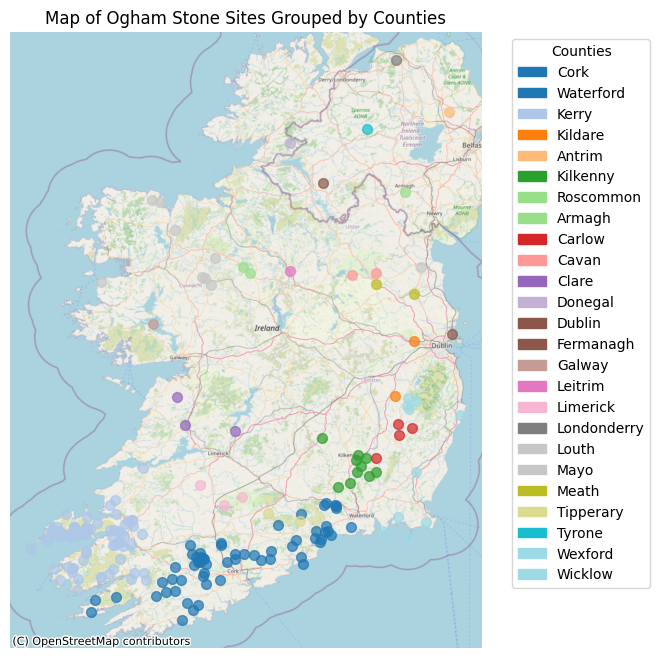

In [26]:
# Map 1: Plot with points coloured by county
fig, ax = plt.subplots(figsize=(12, 8))
unique_counties = gdf['county'].unique()
# Create a colormap with as many colours as unique counties
cmap = plt.get_cmap('tab20', len(unique_counties))
county_colors = {county: cmap(idx) for idx, county in enumerate(unique_counties)}

patches = []
for county, color in county_colors.items():
    county_data = gdf_mercator[gdf_mercator['county'] == county]
    county_data.plot(ax=ax, color=color, markersize=50, alpha=0.7)
    patches.append(Patch(color=color, label=county))  # Add patch for legend

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=8)
ax.set_axis_off()
plt.title("Map of Ogham Stone Sites Grouped by Counties")
plt.legend(handles=patches, title="Counties", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Map 2: Plot with point colours and sizes grouped/styled by stone count

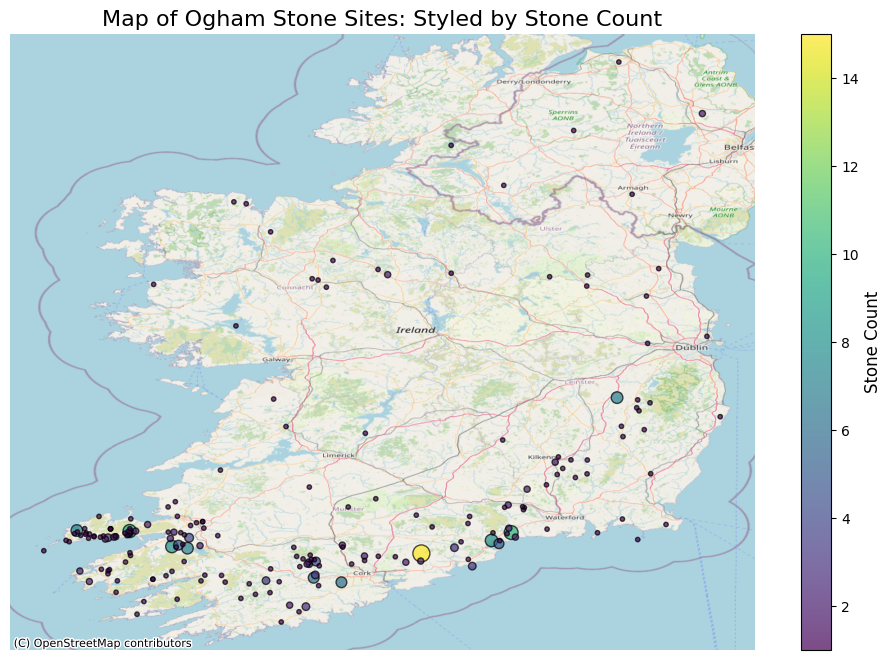

In [27]:
# Map 2: Plot with point colours and sizes grouped/styled by stone count.
fig, ax = plt.subplots(figsize=(12, 8))
# Extract x and y coordinates from the GeoDataFrame.
x = gdf_mercator.geometry.x
y = gdf_mercator.geometry.y

# Define a scaling factor for point sizes.
size_factor = 10
sizes = gdf_mercator["count"] * size_factor

# Plot the points using a continuous colormap (e.g. 'viridis') based on the stone count.
sc = ax.scatter(x, y, s=sizes, c=gdf_mercator["count"], cmap="viridis", alpha=0.7, edgecolor="k")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=8)
ax.set_axis_off()
plt.title("Map of Ogham Stone Sites: Styled by Stone Count", fontsize=16)

# Add a colour bar with label.
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Stone Count", fontsize=12)
plt.show()